In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import scipy as sp 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.exceptions import UndefinedMetricWarning
import seaborn as sns
import pandas as pd
import altair as alt
import warnings

In [23]:
from generate_sample import SampleGenerator
import pymc3.distributions.transforms as tr

import numpy as np

In [16]:
sg = SampleGenerator("poisson", [{'lambda':5}, {'lambda': 10}], 2, 
                     np.array([[0.8, 0.2],[0.2, 0.8]]))

vals_simple, states_orig_simple = sg.generate_samples(100)

In [17]:
df_simple = pd.DataFrame({'vals':vals_simple, 'states':states_orig_simple}).reset_index()

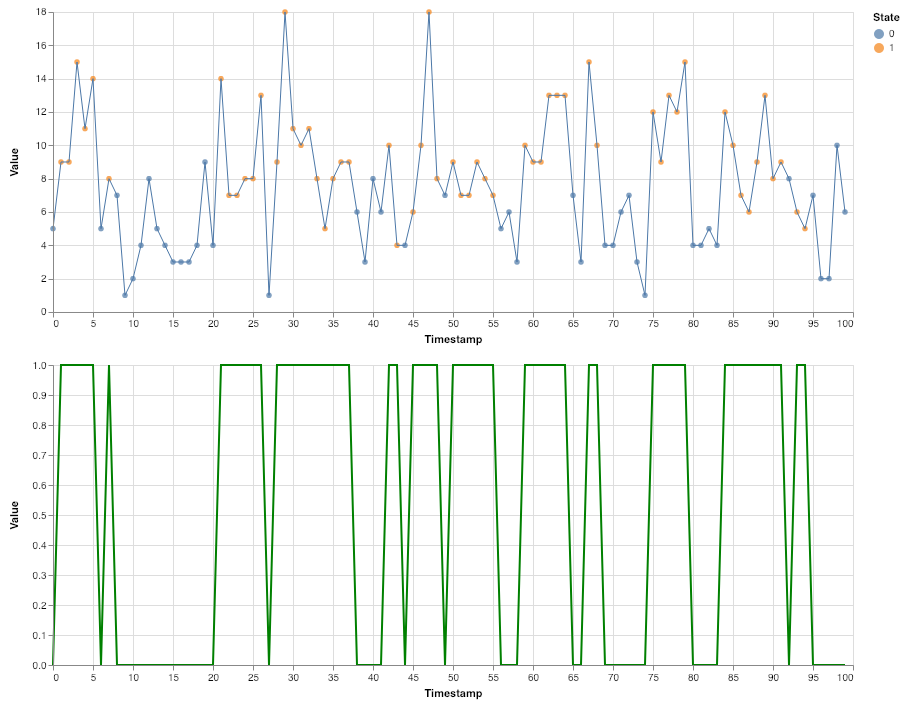

In [235]:
points = alt.Chart(df_simple).mark_circle().encode(
    x = alt.X('index', title='Timestamp'),
    y = alt.Y('vals', title='Value'),
    color =alt.Color('states:N',title='State'),
    tooltip = [alt.Tooltip(field='vals', type='quantitative', title='Value'),
               alt.Tooltip(field='index', type='quantitative', title='Timestamp')]
).properties(
    width=800
)

lines = alt.Chart(df_simple).mark_line().encode(
    size = alt.value(1),
    x='index', #alt.X('index', title='Timestamp'),
    y='vals' #alt.Y('vals', title='Value'),
)



states = alt.Chart(df_simple).mark_line().encode(
    x=alt.X('index', title='Timestamp'),
    y=alt.Y('states', title='Value'),
    size=alt.value(2),
    color=alt.value('green')
).properties(
    width=800
)

points + lines & states



In [237]:
class StateTransitions(pm.Categorical):
    '''
    Distribution of state
    '''
    def __init__(self, trans_prob=None, init_prob=None, * args, ** kwargs):
        
        super(pm.Categorical, self).__init__(* args, ** kwargs)
        
        self.trans_prob = trans_prob
        self.init_prob = init_prob
        
        # Housekeeping
        self.mode = tt.cast(0,dtype='int64')
        self.k = 2
        
    def logp(self, x):
        
        trans_prob = self.trans_prob
        
        p = trans_prob[x[:-1]] # probability of transitioning based on previous state
        x_i = x[1:]            # the state you end up in
        
        log_p = pm.Categorical.dist(p, shape=(self.shape[0],2)).logp_sum(x_i)
        
        return pm.Categorical.dist(self.init_prob).logp(x[0]) + log_p

In [130]:
class PoissionProcess(pm.Discrete):
    
    def __init__(self, state=None, lambdas=None, *args, **kwargs):
        
        super(PoissionProcess, self).__init__(*args, **kwargs)
        
        self.state = state
        self.lambdas = lambdas

        # Housekeeping
        self.mode = tt.cast(1,dtype='int64')
    
    def logp(self, x):
        
        lambd = self.lambdas[self.state]
        llike = pm.Poisson.dist(lambd).logp_sum(x)
            
        return llike

In [24]:
chain_tran = tr.Chain([tr.ordered])

with pm.Model() as m:
    
    lambdas = pm.Gamma('lam0', mu = 10, sd = 100, shape = 2, transform=chain_tran,  testval=np.asarray([1., 1.5]))
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones(2), shape=2)
    state_trans = pm.Dirichlet('state_trans', a = tt.ones(2), shape=(2,2))
    
    states = StateTransitions('states', state_trans, init_probs, shape=len(vals_simple))
    
    y = PoissionProcess('Output', states, lambdas, observed=vals_simple)

In [25]:
with m:
    trace = pm.sample(tune=2000, sample=1000, chains=2)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [state_trans, init_probs, lam0]
>BinaryGibbsMetropolis: [states]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:44<00:00, 111.97draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


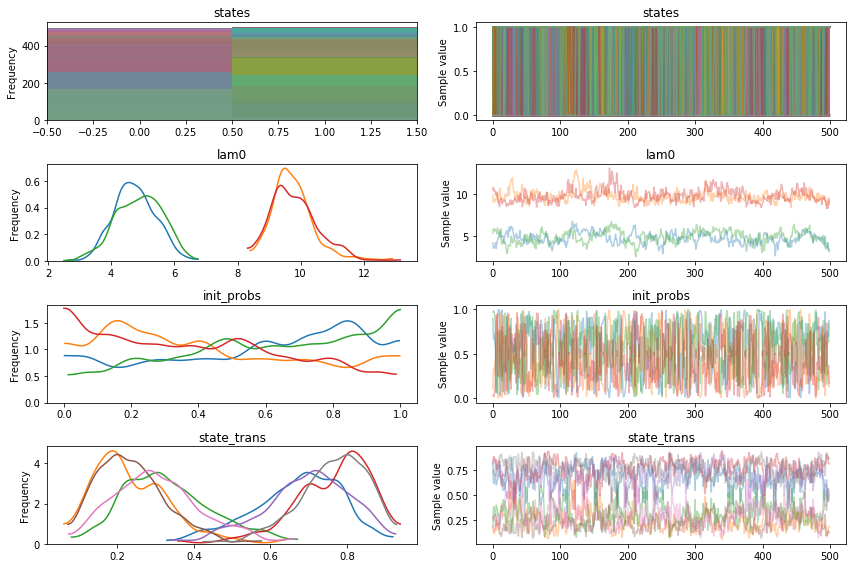

In [26]:
pm.traceplot(trace);

In [27]:
pm.summary(varnames=['state_trans'], trace=trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
state_trans__0_0,0.679363,0.116380,0.007726,0.448393,0.889049,118.827607,1.011713
state_trans__0_1,0.320637,0.116380,0.007726,0.110951,0.551607,118.827607,1.011713
state_trans__1_0,0.238846,0.095465,0.006472,0.071164,0.421701,99.286475,0.999000
state_trans__1_1,0.761154,0.095465,0.006472,0.578299,0.928836,99.286475,0.999000


In [252]:
pm.summary(varnames=['lam0'], trace=trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
lam0__0,4.805044,0.698728,0.053190,3.535222,6.168851,75.734582,1.009833
lam0__1,9.802628,0.727607,0.052656,8.488672,11.269396,78.289001,1.000216


In [28]:
df_simple['inferred_states'] = trace['states'].mean(axis=0)
df_simple['low'] = trace['states'].mean(axis=0) - 2 * trace['states'].std(axis=0) 
df_simple['high'] = trace['states'].mean(axis=0) + 2 * trace['states'].std(axis=0) 

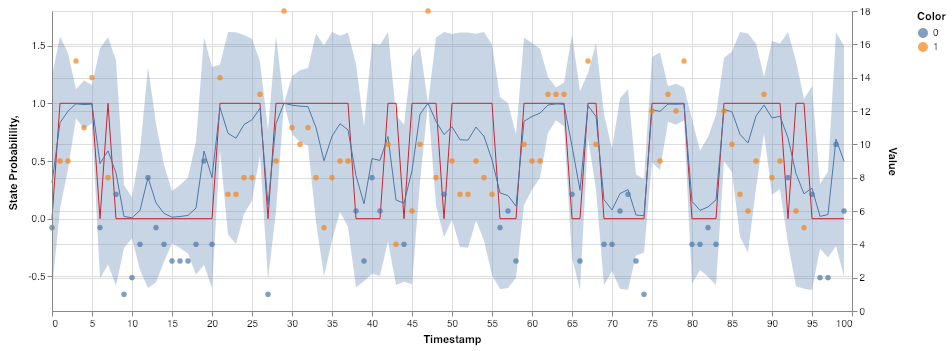

In [246]:
points = alt.Chart(df_simple).mark_circle().encode(
    x = alt.X('index', title='Timestamp'),
    y = alt.Y('vals',title='Value'),
    color =alt.Color('states:N',title='Color'),
    tooltip=[alt.Tooltip(field='index', title='Timestamp', type='quantitative'),
             alt.Tooltip(field='vals', title='Value', type='quantitative')]
).properties(
    width=600
)

lines = alt.Chart(df_simple).mark_line().encode(
    size = alt.value(1),
    x=alt.X('index', title='Timestamp'),
    y=alt.Y('inferred_states', title=''),
)

confidence_interval = alt.Chart(df_simple).mark_area(opacity=0.3).encode(
    x='index',
    y='low',
    y2='high'
)

states = alt.Chart(df_simple).mark_line().encode(
    x=alt.X('index', title='Timestamp'),
    y=alt.Y('states', title='State Probabilility'),
    size=alt.value(1),
    color=alt.value('red')
).properties(
    width=800
)

#points + lines & states

alt.layer(
    states + lines + confidence_interval,
    points,  
).resolve_scale(
    y='independent'
)




0.9628722970216238

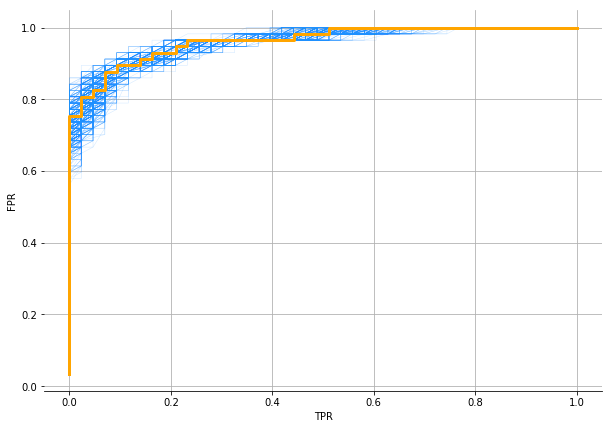

In [250]:
f, ax = plt.subplots(figsize=(10, 7))

fpr, tpr, _ = roc_curve(y_score=df_simple['inferred_states'], y_true=df_simple['states'])
#ax.plot(fpr, tpr, color='green')

for sample in range(1000):
    idx = np.random.choice(trace['states'].shape[0], size = 100)
    mu  = trace['states'][idx, :].mean(axis=0)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        fpr, tpr, _ = roc_curve(y_score=mu, y_true=df_simple['states'])
    ax.plot(fpr, tpr, lw=0.5, alpha = 0.2, color='dodgerblue')
ax.grid()
sns.despine(left=True, bottom=False)

fpr, tpr, _ = roc_curve(y_score=df_simple['inferred_states'], y_true=df_simple['states'])
ax.plot(fpr, tpr, color='orange', lw=3)

ax.set_ylabel('FPR')
ax.set_xlabel('TPR')

plt.savefig("../../../sidravi1.github.io/assets/2019-01-25_simple_ROC.png")
roc_auc_score(y_score=trace['states'].mean(axis=0), y_true=df_simple['states'])

# Hierarchical

In [33]:
n_samples = 100
n_cats = 12

In [41]:
sg3_super = SampleGenerator("poisson", [{'lambda':5}, {'lambda': 15}], 2, 
                     np.array([[0.9, 0.1],[0.1, 0.9]]))
vals_super, states_orig_super = sg3_super.generate_samples(n_samples)

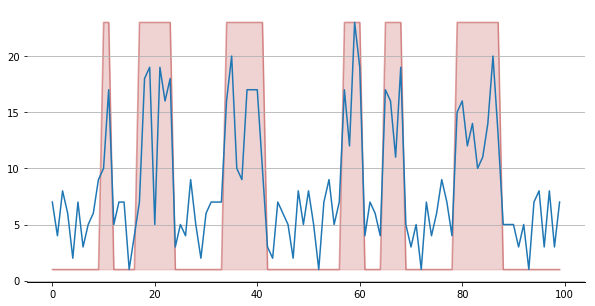

In [253]:
f, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(n_samples), states_orig_super, color='firebrick', alpha = 0.4)
ax2 = ax.twinx()
ax2.plot(np.arange(n_samples), vals_super)
ax.yaxis.set_visible(False)
ax.fill_between(x=np.arange(n_samples), y1=states_orig_super, y2=0, alpha=0.2, color='firebrick')
ax2.grid()
sns.despine(left=True)

plt.savefig("../../../sidravi1.github.io/assets/2019-01-25_hier_super.png")

In [50]:
# sub-categories

vals = np.zeros((n_cats, n_samples))
vals_h = np.zeros((n_cats, n_samples))

stages = np.zeros((n_cats, n_samples))
for sim in range(n_cats):
    
    s1 = sp.stats.dirichlet.rvs(alpha=[18, 2])
    s2 = sp.stats.dirichlet.rvs(alpha=[2, 18])
    transition = np.stack([s1, s2], axis=1).squeeze()

    sg = SampleGenerator("poisson", [{'lambda':5}, {'lambda': 10}], 
                         2, transition)
    
    vals[sim, :], stages[sim, :] = sg.generate_samples(n_samples)
    vals_h[sim, :] = vals[sim, :] + vals_super

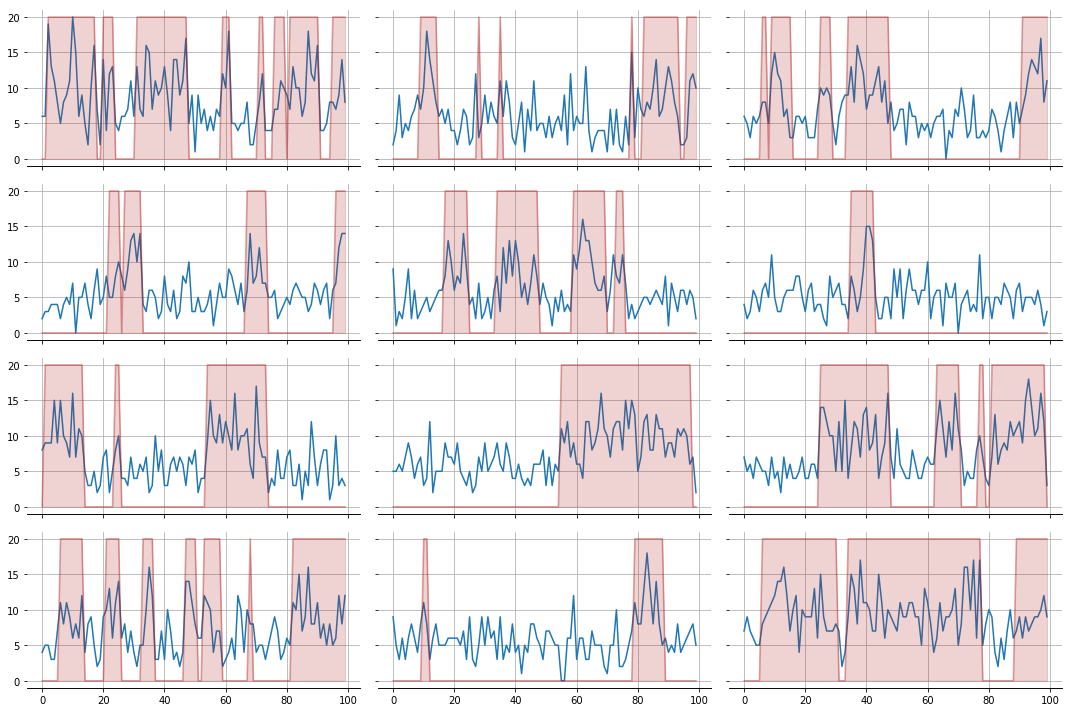

In [254]:
f, axes = plt.subplots(int(np.ceil(n_cats/3)), 3, figsize=(15, 10), sharex=True, sharey=True)
for ax, i in zip(axes.ravel(), np.arange(n_cats)):
    ax.plot(np.arange(n_samples), vals[i])
    ax2 = ax.twinx()
    ax2.plot(np.arange(n_samples), stages[i], color='firebrick', alpha = 0.4)
    ax2.yaxis.set_visible(False)
    ax2.fill_between(x=np.arange(n_samples), y1=stages[i], y2=0, alpha=0.2, color='firebrick')
    ax.grid()
sns.despine(left=True, bottom=False)
plt.tight_layout()

plt.savefig("../../../sidravi1.github.io/assets/2019-01-25_hier_sub.png") 

In [120]:
class HStateTransitions(pm.Categorical):
    
    def __init__(self, trans_prob=None, init_prob=None, *args, **kwargs):
        
        super(pm.Categorical, self).__init__(*args, **kwargs)
        
        self.trans_prob = trans_prob
        self.init_prob = init_prob
        
        # Housekeeping
        self.mode = tt.cast(0,dtype='int64')
        self.k = 2
        
    def logp(self, x):
        
        trans_prob = self.trans_prob
        
        p = trans_prob[x[:-1]] # probability of the previous state you were in
        x_i = x[1:]            # the state you end up in
        
        log_p = pm.Categorical.dist(p, shape=(self.shape[0],1)).logp_sum(x_i)
        initlike = pm.Categorical.dist(self.init_prob).logp(x[0])
        
        return log_p + initlike

In [191]:
class HPoissionProcess(pm.Discrete):
    
    def __init__(self, state=None, state_super=None, lambdas=None, super_lambdas=None, *args, **kwargs):
        
        super(HPoissionProcess, self).__init__(*args, **kwargs)
        
        self.state = state
        self.super_state = state_super
        self.lambdas = lambdas
        self.super_lambdas = lambdas
        
    def logp(self, x):
        
        lambd = self.lambdas[self.state]
        lambd_super = self.super_lambdas[self.super_state]
        
        #llike = pm.Poisson.dist(lambd + lambd_super).logp_sum(x) # since they are independant
        llike = pm.Mixture.dist(w=[0.5, 0.5], comp_dists=[pm.Poisson.dist(lambd), pm.Poisson.dist(lambd_super)]).logp_sum(x)
        
        return llike

In [194]:
chain_tran = tr.Chain([tr.ordered])
with pm.Model() as m2:
    
    lambd = [0] * n_cats
    state_trans = [0] * n_cats
    states = [0] * n_cats
    y = [0] * n_cats
    init_probs = [0] * n_cats
    
    lambd_super = pm.Gamma('lam_super', mu = 10, sd = 10, shape=2, transform=chain_tran,  testval=np.asarray([1., 1.5]))
    init_probs_super = pm.Dirichlet('init_probs_super', a = tt.ones(2), shape=2)
    state_trans_super = pm.Dirichlet('state_trans_super', a = tt.ones(2), shape=(2,2))
    states_super = HStateTransitions('states_super', state_trans_super, init_probs_super, shape=len(vals_super))
    
    for sim in range(n_cats):

        lambd[sim] = pm.Gamma('lam{}'.format(sim), mu = 10, sd = 10, shape=2, 
                              transform=chain_tran, testval=np.asarray([1., 1.5]))
        init_probs[sim] = pm.Dirichlet('init_probs_{}'.format(sim), a = tt.ones(2), shape=2)
        state_trans[sim] = pm.Dirichlet('state_trans{}'.format(sim), a = tt.ones(2), shape=(2,2))
        states[sim] = HStateTransitions('states{}'.format(sim), state_trans[sim], init_probs[sim], shape=n_samples)
        y[sim] = HPoissionProcess('Output{}'.format(sim), states[sim], states_super, lambd[sim], lambd_super, observed=vals_h[sim])


In [123]:
with m2:
    trace2 = pm.sample(tune=4000, sample=1000, init='adapt_diag', chains = 2, target_accept = 0.99)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [state_trans11, init_probs_11, lam11, state_trans10, init_probs_10, lam10, state_trans9, init_probs_9, lam9, state_trans8, init_probs_8, lam8, state_trans7, init_probs_7, lam7, state_trans6, init_probs_6, lam6, state_trans5, init_probs_5, lam5, state_trans4, init_probs_4, lam4, state_trans3, init_probs_3, lam3, state_trans2, init_probs_2, lam2, state_trans1, init_probs_1, lam1, state_trans0, init_probs_0, lam0, state_trans_super, init_probs_super, lam_super]
>BinaryGibbsMetropolis: [states_super, states0, states1, states2, states3, states4, states5, states6, states7, states8, states9, states10, states11]
Sampling 2 chains: 100%|██████████| 9000/9000 [5:44:46<00:00,  1.77s/draws]
There were 427 divergences after tuning. Increase `target_accept` or reparameterize.
There were 396 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler 

In [195]:
with m2:
    trace2_1 = pm.sample(tune=4000, sample=1000, init='adapt_diag', chains = 2, target_accept = 0.99)

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [state_trans11, init_probs_11, lam11, state_trans10, init_probs_10, lam10, state_trans9, init_probs_9, lam9, state_trans8, init_probs_8, lam8, state_trans7, init_probs_7, lam7, state_trans6, init_probs_6, lam6, state_trans5, init_probs_5, lam5, state_trans4, init_probs_4, lam4, state_trans3, init_probs_3, lam3, state_trans2, init_probs_2, lam2, state_trans1, init_probs_1, lam1, state_trans0, init_probs_0, lam0, state_trans_super, init_probs_super, lam_super]
>BinaryGibbsMetropolis: [states_super, states0, states1, states2, states3, states4, states5, states6, states7, states8, states9, states10, states11]
Sampling 2 chains: 100%|██████████| 9000/9000 [2:35:54<00:00,  1.98s/draws]
There were 442 divergences after tuning. Increase `target_accept` or reparameterize.
There were 436 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indica

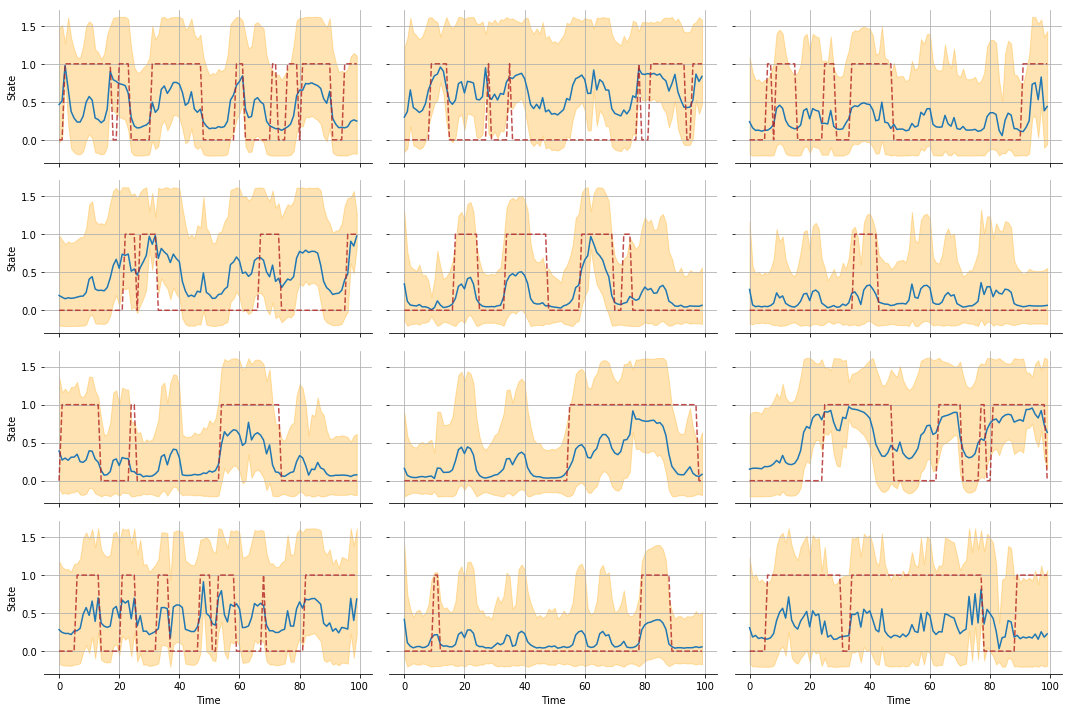

In [259]:
f, axes = plt.subplots(int(np.ceil(n_cats/3)), 3, figsize=(15, 10), sharex=True, sharey=True)
for ax, i in zip(axes.ravel(), np.arange(n_cats)):
    low, med, high = np.percentile(trace2_1['states{}'.format(i)], [5, 50, 95], axis=0)
    #ax.plot(np.arange(n_samples), vals[i])
    mu = np.mean(trace2_1['states{}'.format(i)], axis=0)
    sd = np.std(trace2_1['states{}'.format(i)], axis=0)
    ax.plot(np.arange(n_samples), mu)
    ax.plot(np.arange(n_samples), stages[i], color='firebrick', ls='--', alpha=0.8)
    ax.fill_between(np.arange(n_samples), y1=mu - 1*sd, y2=mu + 2*sd, color='orange', alpha=0.3)
    #ax.fill_between(np.arange(n_samples), y1=low, y2=high, color='orange', alpha=0.3)
    ax.grid()
sns.despine(left=True, bottom=False)

for ax in axes[:, 0]:
    ax.set_ylabel('State')
for ax in axes[-1, :]:
    ax.set_xlabel('Time')    
plt.tight_layout()

plt.savefig("../../../sidravi1.github.io/assets/2019-01-25_hier_sub_results.png")

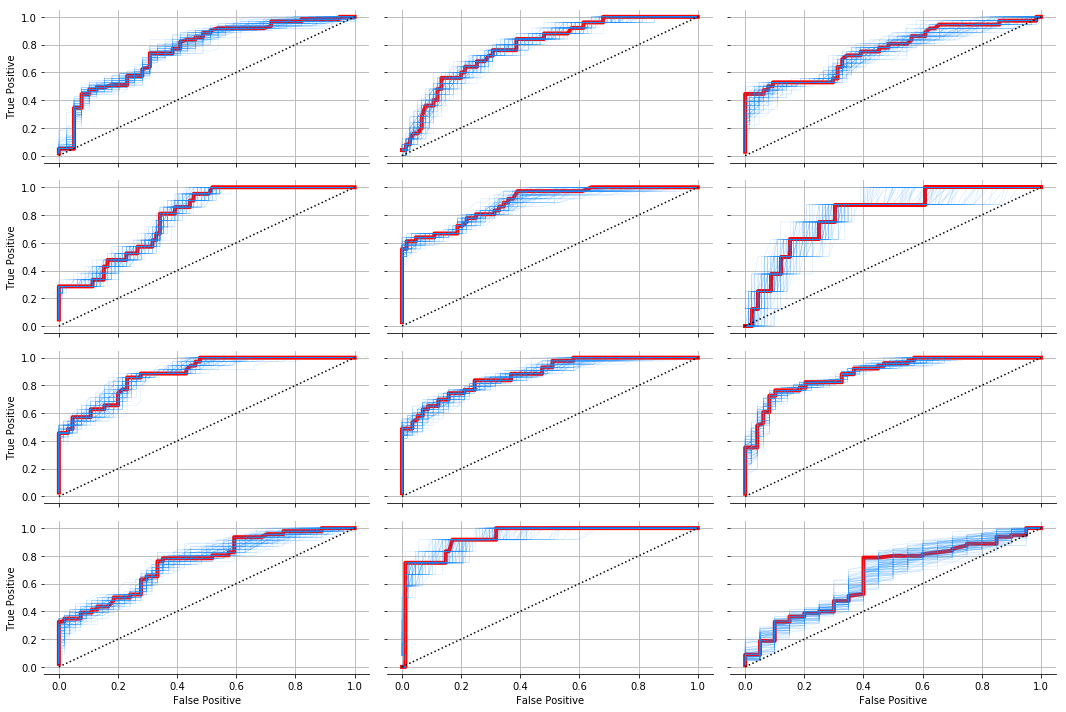

In [260]:
import warnings

f, axes = plt.subplots(int(np.ceil(n_cats/3)), 3, figsize=(15, 10), sharex=True, sharey=True)
for ax, i in zip(axes.ravel(), np.arange(n_cats)):
    y_true = stages[i]
    y_pred = np.mean(trace2_1['states{}'.format(i)], axis=0)
    fpr, tpr, _ = roc_curve(y_score=y_pred, y_true=y_true)
    ax.plot(fpr, tpr, lw=4, color='r')
    
    for sample in range(100):
        idx = np.random.choice(trace2_1['states{}'.format(i)].shape[0], size = 300)
        mu  = trace2_1['states{}'.format(i)][idx, :].mean(axis=0)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            fpr, tpr, _ = roc_curve(y_score=mu, y_true=y_true)
        ax.plot(fpr, tpr, lw=0.5, alpha = 0.2, color='dodgerblue')
    ax.grid()
    ax.plot([0, 1], [0, 1], ":k")
sns.despine(left=True, bottom=False)

for ax in axes[:, 0]:
    ax.set_ylabel('True Positive')
for ax in axes[-1, :]:
    ax.set_xlabel('False Positive')   
    
plt.tight_layout()

plt.savefig("../../../sidravi1.github.io/assets/2019-01-25_hier_sub_roc.png")

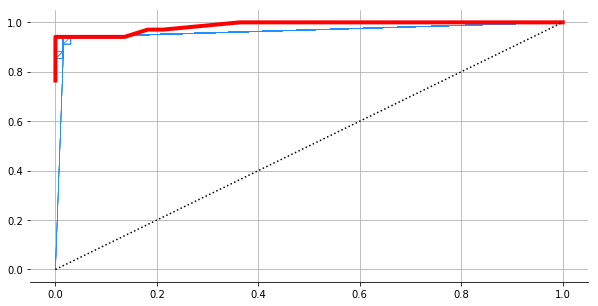

In [264]:
f, ax = plt.subplots(figsize=(10, 5))

y_true = states_orig_super
y_pred = np.mean(trace2_1['states_super'], axis=0)

for sample in range(1000):
    idx = np.random.choice(trace2_1['states_super'].shape[0], size = 100)
    mu  = trace2['states_super'][idx, :].mean(axis=0)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        fpr, tpr, _ = roc_curve(y_score=mu, y_true=y_true)
    ax.plot(fpr, tpr, lw=0.5, alpha = 0.2, color='dodgerblue')
ax.grid()
sns.despine(left=True, bottom=False)

fpr, tpr, _ = roc_curve(y_score=y_pred, y_true=y_true)
ax.plot(fpr, tpr, lw=4, color='r')
ax.plot([0, 1], [0, 1], ":k")

plt.savefig("../../../sidravi1.github.io/assets/2019-01-25_hier_super_roc.png")

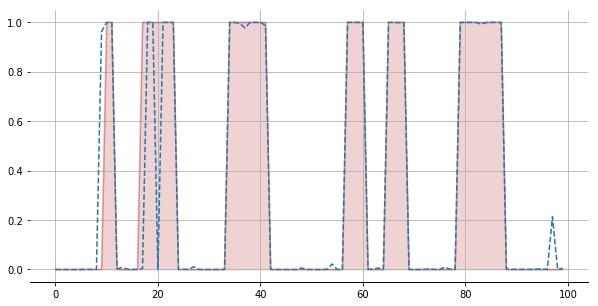

In [262]:
f, ax = plt.subplots(figsize=(10,5))
ax.plot(np.arange(n_samples), states_orig_super, color='firebrick', alpha = 0.4)
ax2 = ax.twinx()
ax.fill_between(x=np.arange(n_samples), y1=states_orig_super, y2=0, color='firebrick', alpha = 0.2)
y_pred = np.mean(trace2_1['states_super'], axis=0)
ax2.plot(np.arange(n_samples), y_pred, '--')
ax2.yaxis.set_visible(False)
ax.grid()
sns.despine(left=True)

plt.savefig("../../../sidravi1.github.io/assets/2019-01-25_hier_super_results.png")

# Heirarchical Mixture model

In [555]:
class PoissionProcess(pm.Discrete):
    
    def __init__(self, state=None, lambdas=None, *args, **kwargs):
        
        super(PoissionProcess, self).__init__(*args, **kwargs)
        
        self.state = state
        self.lambdas = lambdas
        
        self.mode = tt.cast(0,dtype='int64')
        self.k = 2
        
    def logp(self, x):
        
        lambd = self.lambdas[self.state]
        llike = pm.Poisson.dist(lambd).logp_sum(x)
            
        return llike

In [578]:
import pymc3.distributions.transforms as tr

chain_tran = tr.Chain([tr.log, tr.ordered])

with pm.Model() as m3:
    
    lambd = [0] * n_cats
    state_trans = [0] * n_cats
    states = [0] * n_cats
    y = [0] * n_cats
    sub_proc = [0] * n_cats
    
    lambd_super = pm.Gamma('lam_super', mu = 50, sd = 100, shape=2, transform=chain_tran,  testval=np.asarray([1., 1.5]))
    #init_probs_super = pm.Dirichlet('init_probs_super', a = tt.ones(2), shape=2)
    state_trans_super = pm.Dirichlet('state_trans_super', a = tt.ones(2), shape=(2,2))
    states_super = HStateTransitions('states_super', state_trans_super, shape=len(vals_super))
    proc_super = PoissionProcess.dist(states_super, lambd_super)
    
    #w = pm.Dirichlet('w', a=np.array([1, 1]), shape=(n_cats, 2))
    
    for sim in range(n_cats):
        
        lambd[sim] = pm.Gamma('lam{}'.format(sim), mu = 50, sd = 50, shape=2, 
                              transform=chain_tran, testval=np.asarray([1., 1.5]))
        
        state_trans[sim] = pm.Dirichlet('state_trans{}'.format(sim), a = tt.ones(2), shape=(2,2))
        states[sim] = HStateTransitions('states{}'.format(sim), state_trans[sim], shape=n_samples)
        sub_proc[sim] = PoissionProcess.dist(states[sim], lambd[sim])
        
        y = pm.Mixture('mix{}'.format(sim), comp_dists=[proc_super, sub_proc[sim]], w=np.array([0.5, 0.5]), observed=vals_h[sim])


In [579]:
with m3:
    trace3 = pm.sample(tune=3000, sample=1000, init='adapt_diag', n_chains=2, target_accept=0.95)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [state_trans9, lam9, state_trans8, lam8, state_trans7, lam7, state_trans6, lam6, state_trans5, lam5, state_trans4, lam4, state_trans3, lam3, state_trans2, lam2, state_trans1, lam1, state_trans0, lam0, state_trans_super, lam_super]
>BinaryGibbsMetropolis: [states_super, states0, states1, states2, states3, states4, states5, states6, states7, states8, states9]
Sampling 4 chains: 100%|██████████| 14000/14000 [40:07<00:00,  2.00draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.30549494740734184, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
Th

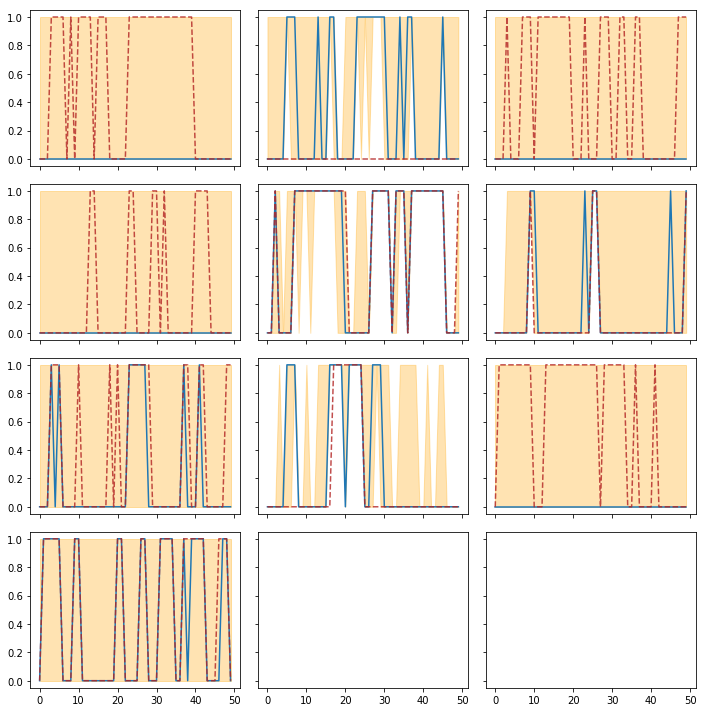

In [581]:
f, axes = plt.subplots(int(np.ceil(n_cats/3)), 3, figsize=(10, 10), sharex=True, sharey=True)
for ax, i in zip(axes.ravel(), np.arange(n_cats)):
    low, med, high = np.percentile(trace3['states{}'.format(i)], [5, 20, 95], axis=0)
    ax.plot(np.arange(n_samples), med)
    ax.plot(np.arange(n_samples), stages[i], color='firebrick', ls='--', alpha=0.8)
    ax.fill_between(np.arange(n_samples), y1=low, y2=high, color='orange', alpha=0.3)
    
plt.tight_layout()

In [165]:
init = np.array([1, 1, 1, 0])
left = np.array([[1, 0, 0, 0],[1, 0, 0, 0],[1/3, 1/3, 0, 1/3], [0, 0, 1, 0]])
right = np.array([[0, 1, 0, 0],[0, 0, 1, 0],[1/3, 1/3, 0, 1/3],[0, 0, 0, 1]])

In [187]:
left

array([[1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333],
       [0.        , 0.        , 1.        , 0.        ]])

In [188]:
right

array([[0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.33333333, 0.33333333, 0.        , 0.33333333],
       [0.        , 0.        , 0.        , 1.        ]])

In [162]:
mat = (left @ right @ left).sum(axis=0) / (left @ right @ left).sum()

In [181]:
mat = ((left * init) @ right @ left)

In [185]:
a = mat.sum(axis=1) / mat.sum()
a

array([0.27272727, 0.27272727, 0.18181818, 0.27272727])

0.18181818181818185

In [ ]:
pm.ZeroInflatedPoisson(psi=)